In [1]:
# %pip install torchtnt

In [1]:
import os
from glob import glob
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline

In [3]:
col_to_remove = [
    "amt_disc_ea",
    "amt_gross",
    "amt_net",
    "amt_net_forex",
    "canceled",
    "class_code",
    "code",
    "color_code",
    "cost_center",
    "created_at",
    "currency",
    "customer_code",
    "deleted_at",
    "department_code",
    "discount_granted_excl",
    "discountflag",
    "document_currency",
    "document_number",
    "document_type",
    "family_code",
    "filename",
    "flag_delete",
    "gender_code",
    "geography",
    "gl_account",
    "gl_devise",
    "gl_etablissement",
    "gl_model",
    "gl_numero",
    "gl_numligne",
    "gl_puht",
    "gl_refartbarre",
    "gl_remiseligne",
    "gl_tiers",
    "gl_totalht",
    "gp_refexterne",
    "group_code",
    "id",
    "id_class",
    "id_collection",
    "id_color",
    "id_department",
    "id_family",
    "id_gender",
    "id_group",
    "id_loader_job",
    "id_subclass",
    "libdim1",
    "pays",
    "price_ea",
    "product_id",
    "rate",
    "rn",
    "subclass_code",
    "upc",
]

In [4]:
if os.path.exists("raw_dataset.brotly.parquet"):
    df = pd.read_parquet("raw_dataset.brotly.parquet")
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True)
else:
    df_sales_cl = pd.concat([pd.read_parquet(f) for f in glob("cl1_sales*.parquet")])
    df_sales_cl = df_sales_cl[~df_sales_cl["product_color"].isna()]
    df_sales_cl["canceled"] = df_sales_cl["canceled"].str.strip()
    df_sales_cl = (
        df_sales_cl[~df_sales_cl["canceled"].isin(["C", "Y"])]
        .reset_index(drop=True)
        .rename(
            columns={"posting_date": "date", "product_color": "sku", "quantity": "qty"}
        )
    )
    [df_sales_cl.pop(col) for col in col_to_remove if col in df_sales_cl]
    df_sales_cl = df_sales_cl[df_sales_cl["sku"].str.contains(r"\b\w{7}-\w{5}-\w{3}\b")]

    df_sales_ce = pd.concat([pd.read_parquet(f) for f in glob("df_sales*.parquet")])
    df_sales_ce = (
        df_sales_ce[~df_sales_ce["gl_codearticle"].isna()]
        .reset_index(drop=True)
        .rename(
            columns={
                "gl_datepiece": "date",
                "gl_codearticle": "sku",
                "gl_qtefact": "qty",
            }
        )
    )
    df_sales_ce = df_sales_ce[df_sales_ce["sku"].str.contains(r"\b\w{7}-\w{5}-\w{3}\b")]
    [df_sales_ce.pop(col) for col in col_to_remove if col in df_sales_ce]

    df = pd.concat([df_sales_ce, df_sales_cl]).convert_dtypes()

    df = df[df["qty"] > 0]
    df["sku"] = df["sku"].str.strip()
    df["date"] = pd.to_datetime(df["date"])
    df.sort_values("date", inplace=True)
    df = df.convert_dtypes().reset_index(drop=True).copy()
    df.to_parquet("raw_dataset.brotly.parquet", compression="brotli")
    df.set_index("date", inplace=True)
    display(df.groupby("sku").size().sort_values().tail())

sku
MJT021H-00535-068    25694
MJT022H-00535-461    27101
MJQ008H-00535-068    28736
MJT021H-00535-461    30365
MJQ008H-00535-461    35806
dtype: int64

# Feature engineering
### Time
 - Decompose in `t_sin` and `t_cos`
### Seasons
 - Split `market_seasons` by `|` and concat with `seasons`, `market_season`, `season`
### Sizes
 - Split `sizes` by `|` and concat with `size`
### Channels
 - Split `channels` by `|` and concat with `channel`
### Brands
 - Split `brands` by `|` and concat with `brand`
### Collections
 - Split `collections` by `|` and concat with `collections`

In [5]:
def get_features(entry, col_feature):
    features = []
    cols = [col for col in entry.index if col_feature in col]
    print(cols)
    for col in cols:
        print(col)
        if entry[col] and isinstance(entry[col], str):
            features.extend([v.strip() for v in entry[col].split("|")])
            del entry[col]
    entry[col_feature] = list(set(features))


def get_features(df, col_feature):
    features = []
    cols = [col for col in df if col_feature in col]
    for col in cols:
        unique_values = [v for v in df.pop(col).unique() if not pd.isnull(v)]
        try:
            for value in unique_values:
                features.extend([v.strip() for v in value.split("|")])
        except Exception as e:
            print(col, value)
            raise e
    features = [f for f in list(set(features)) if len(f) > 0]
    df[col_feature] = [features for _ in range(len(df))]


# _series = _df.resample("1W").agg(agg).ffill()
# for feature in ["size", "season", "channel", "brand", "collection"]:
#     get_features(_series, feature)

In [7]:
from tqdm.notebook import tqdm

if os.path.exists("raw_timeseries.parquet"):
    series = pd.read_parquet("raw_timeseries.parquet")
else:
    series_list = []
    for sku, _df in tqdm(df.groupby("sku")):
        #
        agg = dict(zip(_df.keys(), ["last"] * len(_df.columns))) | {"qty": "sum"}
        _series = _df.resample("1W").agg(agg).ffill().bfill()
        [
            get_features(_series, feature)
            for feature in ["size", "season", "channel", "brand", "collection"]
        ]
        series_list.append(_series)
    series = pd.concat(series_list).sort_index()
    series.to_parquet("raw_timeseries.parquet", compression="brotli")

  0%|          | 0/30240 [00:00<?, ?it/s]

In [8]:
print(len(series))
mask = series.isna().any(axis=1)
series = series[~mask].reset_index().copy()
print(len(series))

3317114
3257143


<Axes: xlabel='date'>

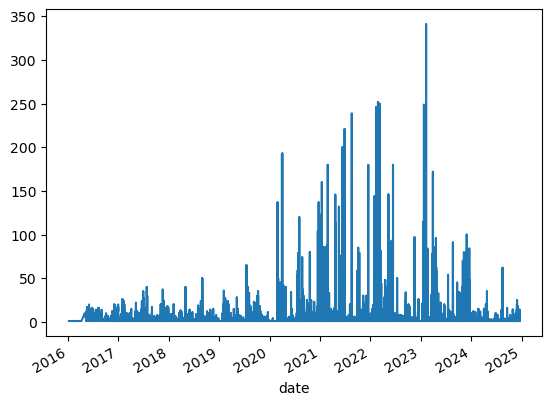

In [9]:
df[df["sku"] == "MJQ008H-00535-461"].sort_values("date")["qty"].plot()

<Axes: >

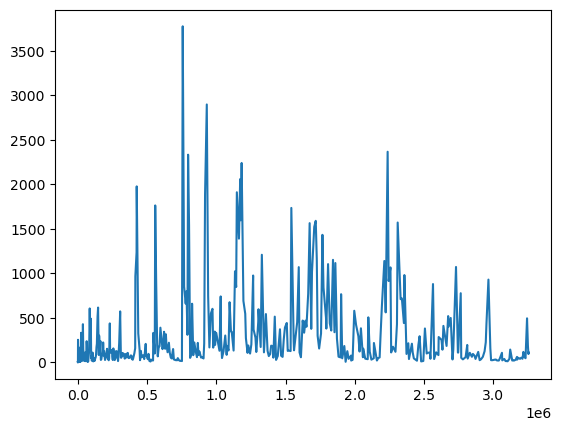

In [10]:
series[series["sku"] == "MJQ008H-00535-461"]["qty"].plot()

In [11]:
def create_timeseries(X, y, window=10, n_out=1, shift=0):
    _X, _y = [], []
    for i in range(len(X) - (window + n_out + shift)):
        _X.append(X[i : i + window])
        _y.append(y[i + window + shift : i + window + shift + n_out])
    return np.asarray(_X), np.asarray(_y)


print(np.asarray(range(10)))
_x, _y = create_timeseries(np.asarray(range(10)), np.asarray(range(10)), 3, 1, 0)
_x.shape, _y.shape, _x, _y

[0 1 2 3 4 5 6 7 8 9]


((6, 3),
 (6, 1),
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6],
        [5, 6, 7]]),
 array([[3],
        [4],
        [5],
        [6],
        [7],
        [8]]))

In [12]:
# Using 1 year of history data (52 weeks)
window = 52
# Predicting out 1 months (4 weeks)
n_out = 8

In [13]:
# Removing SKUs that does not has at least:
# - 1 example for train and 1 for test
# - 70% of empty data
skus_to_remove = (
    series.groupby("sku")
    .filter(
        lambda x: len(x) <= (window + n_out + 2)
        or (x["qty"] == 0).sum() / len(x) >= 0.7
    )["sku"]
    .unique()
)
mask = series["sku"].isin(skus_to_remove)
_percent_sku_removed = round(len(skus_to_remove) / len(series["sku"].unique()) * 100, 2)
_percent_entries_removed = round(mask.sum() / len(mask) * 100, 2)
print(
    f"Removing {_percent_sku_removed}% of SKUs [{_percent_entries_removed}% total entries]"
)
series = series[~mask].copy()

Removing 83.99% of SKUs [80.14% total entries]


In [14]:
series

,date,sku,qty,description,composition,gender_description,department_description,class_description,group_description,color_description,family_description,subclass_description,division,size,season,channel,brand,collection
0,2016-01-10,MJQ008B-00074-461,1,CLASSIC SWEATPANTS W/ 4 BAR,,Mens,MR_RTW,RJW_SWEATS,MRJ_JERSEY,NAVY,NOT DEFINED,MRJWA_SWEATPANTS,Thom Browne Japan (Europe),"[1, 0, 5, 00, 4, 2, 3]",[],[],[],"[1, 001]"
1,2016-01-10,MWL001A-00139-100,1,CLASSIC L/S BD PC SHIRT IN OXFORD,SELF:100% COTTON,Mens,MR_RTW,RWS_SHIRT_BLOUSE,MRW_WOVENS,WHITE,CLASSIC CARRYOVER,MRWSL_LONG_SLEEVE,"Thom Browne, Inc.","[1, 0, 5, 00, 4, 2, 3]","[SS20, FW21, SS24, STOCK, SPRING 1, FW23, SS25...","[W, INC, CL, R]","[BM01, BW01]","[CO-1, WOMENS 2, SPRING 1, MENS 1, 4, 22, MENS..."
2,2016-01-10,MJQ008H-00535-025,2,CLASSIC SWEATPANT IN CLASSIC LOOPBACK W/ ENGIN...,SELF:100% COTTON,Mens,MR_RTW,RJW_SWEATS,MRJ_JERSEY,DARK GREY,CLASSIC CARRYOVER,MRJWA_SWEATPANTS,Thom Browne Japan,"[1, 3, 5, 00, 4, 2, 0]","[SS20, FW21, SS24, STOCK, SS25, FW23, SS22, SS...","[W, INC, E, C, CL, R]","[BM01, BW01]","[CO-1, WOMENS SPRING 1, SPRING 1, WOMENS EARLY..."
3,2016-01-10,MKC001A-00011-038,1,CLASSIC V NECK CARDIGAN W/ WHITE 4 BAR STRIPE ...,SELF:100% CASHMERE,Mens,MR_RTW,RKC_CARDIGAN,MRK_KNIT,MED GREY,CLASSIC CARRYOVER,MRKCL_LONG_SLEEVE,"Thom Browne, Inc.","[1, 3, 5, 00, 4, 2, 0]","[SS20, MILAN, FW21, SS24, STOCK, SS25, FW23, S...","[W, INC, E, C, CL]","[BM01, BW01]","[CO-1, UNIFORM, SPRING 1, WOMENS EARLY, MENS 1..."
5,2016-01-10,MKC002A-00014-038,1,CLASSIC V-NECK CARDIGAN IN FINE MERINO WOOL,SELF: 100% WOOL,Mens,MR_RTW,RKC_CARDIGAN,MRK_KNIT,MED GREY,CLASSIC CARRYOVER,MRKCL_LONG_SLEEVE,Thom Browne Japan,"[1, 0, 5, 00, 4, 2, 3]","[SS20, FW21, SS24, STOCK, FW23, SS25, SS22, SS...","[W, INC, E, C, CL, R]","[BM01, BW01]","[CO-1, WOMENS SPRING 1, SPRING 1, MENS 1, MENS..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257135,2024-12-22,MAG328F-03793-035,2,GARDEN TOTE IN FUNMIX SHETLAND - L42 H42 W15,SELF:100% WOOL: COMBO1:100% CALF FULL GRAIN LE...,Mens,ML_LEATHER_GOODS,LBE_TOTE,MLB_BAGS,MED GREY,NOT DEFINED,MLBEN_NOVELTY,Thom Browne Trading (T.B.T) SA LIVE,[O/S],"[FW21, SS24, FW23, SS22, SS23, FW22, FW24]","[W, INC]",[BM01],"[WOMENS FALL 2, CO, CO-4, WOMENS 2, 1, CO4, ME..."
3257138,2024-12-22,MJT361A-06772-415,1,BUTTON DOWN SHIRT JACKET IN DOUBLE FACE TECH T...,SELF:100% COTTON: COMBO1:100% COTTON,Mens,MR_RTW,RJJ_JACKET,MRJ_JERSEY,NAVY,NOT DEFINED,MRJJS_SHORT,Thom Browne Trading (T.B.T) SA LIVE,"[1, 0, 5, 00, 4, 2, 3]","[SS24, SS25, FW23, SS23, FW24]","[W, INC]",[BM01],"[CO-1, 1, 001, MENS CARRYOVER, 2]"
3257139,2024-12-22,KOD001X-08031-415,1,OVERSIZED HOODED FOOTBALL PARKA W/ RWB ARMBAND...,SELF:100% POLYESTER: LINING:100% CUPRO,Kids,KR_RTW,RWO_OUTERWEAR,KRW_WOVENS,NAVY,NOT DEFINED,KRWOD_DOWNFILL,Thom Browne Trading (T.B.T) SA LIVE,"[6, 12, 10, 4, 8, 2]","[SS24, FW23, SS25, SS22, SS23, FW22, FW24]","[W, INC]",[BK01],"[CO-1, CO-4, KIDS CARRYOVER, 1, CO4, KIDS 2, K..."
3257140,2024-12-22,MJU527A-03788-275,1,UNCONSTRUCTED CLASSIC SPORT COAT - FIT 1 - W/ ...,SELF:100% COTTON: LINING:100% CUPRO,Mens,MR_RTW,RWP_SPORT_COAT,MRW_WOVENS,CAMEL,CLASSIC CARRYOVER,MRWPA_FIT_1,Thom Browne Inc. LIVE,"[1, 3, 5, 00, 4, 2, 0]","[FW21, SS24, FW23, SS25, SS22, SS21, SS23, FW2...","[W, INC]",[BM01],"[CO-1, 2, CO, MENS EARLY, MAIN, 1, CO-2, CO-3,..."


In [ ]:
series.sample(2).to_dict(orient="records")

In [ ]:
sku_to_index = {sku: idx for idx, sku in enumerate(series["sku"].unique())}
series["sku_code"] = series["sku"].map(sku_to_index)

In [ ]:
# Create time features. Decompose the time "signal" using cos and sin coordinates.
# By this, the first week of the year is nearest point of the last week instead of the farthest.
# FIXME: We use only the week number (1-52 i think), add features related to holiday and month instead of the week number only)
# FIXME: Take care about the COVID period in order to add an external bias factor for influence the 2020-2022 sales.
#   Note that batch size can influence the generalization of the network and reduce the sales due to the decrease of the sales.
calendar = series.index.isocalendar().week
series["t_sin"] = np.sin(calendar * (2 * np.pi / calendar.max()))
series["t_cos"] = np.cos(calendar * (2 * np.pi / calendar.max()))
display(series[series["sku"] == "MJQ012H-00535-068"][["t_sin", "t_cos"]].plot())
series[series["sku"] == "MJQ012H-00535-068"][["qty"]].plot()

In [ ]:
sku_list = series.pop("sku")

In [ ]:
ts_train_x_dataset = []
ts_train_y_dataset = []
ts_test_x_dataset = []
ts_test_y_dataset = []
grouped = series.groupby("sku_code")

for sku, _series in tqdm(grouped):
    _ts, _y = create_timeseries(_series, _series["qty"], window=window, n_out=n_out)
    _ts_train, _ts_test, _y_train, _y_test = train_test_split(
        _ts, _y, test_size=0.2, shuffle=False
    )
    ts_train_x_dataset.extend(_ts_train)
    ts_test_x_dataset.extend(_ts_test)
    ts_train_y_dataset.extend(_y_train)
    ts_test_y_dataset.extend(_y_test)

In [ ]:
_series.head(1).to_dict(orient="records")

In [ ]:
ts_train_x_dataset = np.asarray(ts_train_x_dataset)
ts_train_y_dataset = np.asarray(ts_train_y_dataset)
ts_test_x_dataset = np.asarray(ts_test_x_dataset)
ts_test_y_dataset = np.asarray(ts_test_y_dataset)

In [ ]:
len(ts_train_x_dataset), len(ts_test_x_dataset)

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset


class DemandDataset(Dataset):
    def __init__(self, raw_dataset, y):
        self.raw_dataset = raw_dataset
        self.y = y

    def __len__(self):
        return len(self.raw_dataset)

    def __getitem__(self, idx):
        return {"sequence": self.raw_dataset[idx], "y": self.y[idx]}

    def collate_fn(self, batch):
        qty = torch.as_tensor(
            [x["sequence"][:, 0] for x in batch], dtype=torch.float32
        ).unsqueeze(-1)
        sku = torch.as_tensor(
            [x["sequence"][:, 1][0] for x in batch], dtype=torch.int32
        )
        time = torch.as_tensor(
            [x["sequence"][:, 2:] for x in batch], dtype=torch.float32
        )
        y = torch.as_tensor([x["y"] for x in batch], dtype=torch.float32)
        return {"qty": qty, "sku": sku, "time": time, "y": y}

In [ ]:
from gc import collect

collect()
torch.cuda.empty_cache()

In [ ]:
batch_size = 256
ds_train = DemandDataset(ts_train_x_dataset, ts_train_y_dataset)
dl_train = DataLoader(
    ds_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    collate_fn=ds_train.collate_fn,
    pin_memory=True,
    drop_last=True,
)

ds_test = DemandDataset(ts_test_x_dataset, ts_test_y_dataset)
dl_test = DataLoader(
    ds_test,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=ds_test.collate_fn,
    pin_memory=True,
    drop_last=True,
    num_workers=2,
)
if torch.cuda.is_available():
    device = torch.device("cuda")
    from torchtnt.utils.data import CudaDataPrefetcher

    dl_train = CudaDataPrefetcher(dl_train, device, 32)
    dl_test = CudaDataPrefetcher(dl_test, device, 32)
else:
    device = torch.device("cpu")

In [ ]:
for x_ds in ds_train:
    break
for x_dl in dl_train:
    break

In [ ]:
# Model
class DemandForecastingModel(nn.Module):
    def __init__(
        self, n_skus, embedding_dim, input_size, hidden_size, num_layers, n_out
    ):
        super(DemandForecastingModel, self).__init__()
        self.sku_embedding = nn.Embedding(n_skus, embedding_dim)  # SKU embedding
        self.lstm = nn.LSTM(
            input_size + embedding_dim, hidden_size, num_layers, batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, n_out),
        )
        self.normalizer = nn.LayerNorm((batch_size, window, input_size + embedding_dim))

    def forward(self, qty, sku, time):
        # Embed SKU
        sku_emb = self.sku_embedding(sku)  # [batch_size, embedding_dim]
        # Expand to [batch_size, seq_length, embedding_dim]
        sku_emb = sku_emb.unsqueeze(1).repeat(1, qty.size(1), 1)
        # Concatenate features
        x = torch.cat([qty, time, sku_emb], dim=-1)
        # [batch_size, seq_length, input_size + embedding_dim]
        # Pass through LSTM
        x = self.normalizer(x)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the output of the last time step
        return out


collect()
torch.cuda.empty_cache()

# Initialize model, loss, and optimizer
input_size = x_dl["qty"].shape[-1] + x_dl["time"].shape[-1]  # qty + time features
embedding_dim = 64
hidden_size = 128
num_layers = 4
learning_rate = 0.001
num_epochs = 20
model = DemandForecastingModel(
    len(series["sku_code"].unique()),
    embedding_dim,
    input_size,
    hidden_size,
    num_layers,
    n_out,
).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Training Loop
model.train()
total_steps = len(dl_train.data_iterable.dataset) // batch_size
for epoch in tqdm(range(num_epochs), desc="epochs", position=0):
    epoch_loss = 0.0
    for batch in tqdm(dl_train, position=1, leave=False, total=total_steps):
        qty = batch["qty"]  # [batch_size, seq_length, 1]
        sku = batch["sku"]  # [batch_size]
        time = batch["time"]  # [batch_size, seq_length, 2]
        y = batch["y"]

        # Forward pass
        outputs = model(qty, sku, time)
        loss = criterion(outputs.squeeze(), y.squeeze())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / total_steps:.4f}")

# Save the trained model
torch.save(model.state_dict(), "demand_forecasting_model_with_time_features.pth")

In [ ]:
import matplotlib.pyplot as plt


# Validation on the test dataset
def validate_model(model, dataloader, criterion, scaler=None):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    predictions = []
    actuals = []
    total_steps = len(dataloader.data_iterable.dataset) // batch_size
    with torch.no_grad():
        for batch in tqdm(dataloader, total=total_steps):
            qty = batch["qty"]  # [batch_size, seq_length]
            sku = batch["sku"]  # [batch_size]
            time = batch["time"]  # [batch_size, seq_length, time_features_dim]
            targets = batch["y"]  # Actual target values
            # Forward pass
            outputs = model(qty, sku, time)
            loss = criterion(outputs.squeeze(), targets.squeeze())
            total_loss += loss.item()

            # Store predictions and actual values
            predictions.extend(outputs.squeeze().detach().cpu().numpy())
            actuals.extend(targets.detach().cpu().numpy())

    avg_loss = total_loss / total_steps
    return predictions, actuals, avg_loss


# Validate the model on the test dataset
predictions, actuals, avg_loss = validate_model(model, dl_test, criterion)

# Plot predictions vs actuals
plt.figure(figsize=(10, 6))
plt.plot(actuals, label="Actual", color="blue")
plt.plot(predictions, label="Predicted", color="red", linestyle="dashed")
plt.title(f"Demand Forecasting: Actual vs Predicted (Loss: {avg_loss:.4f})")
plt.xlabel("Sample Index")
plt.ylabel("Quantity")
plt.legend()
plt.grid()
plt.show()

# Calculate performance metrics
mse = np.mean((np.array(actuals) - np.array(predictions)) ** 2)
mae = np.mean(np.abs(np.array(actuals) - np.array(predictions)))
print(
    f"Validation Results:\nMean Squared Error (MSE): {mse:.4f}\nMean Absolute Error (MAE): {mae:.4f}"
)